In [1]:
import cv2
import re
import numpy as np
from PIL import Image
from IPython import display
import time

dirs=">v<^"
deltas={}
deltas['>']=[ 1, 0]
deltas['v']=[ 0, 1]
deltas['<']=[-1, 0]
deltas['^']=[ 0,-1]

td="""#.#####
#.....#
#>....#
#.....#
#...v.#
#.....#
#####.#"""

td2="""#.######
#>>.<^<#
#.<..<<#
#>v.><>#
#<^v^^>#
######.#"""


def parse(d):
    M={}
    b=[]
    d=d.split('\n')
    for y,l in enumerate(d):
        for x,v in enumerate(l):
            p=(x,y)
            if v in ".v<>^":
                M[p]=1
            else:
                M[p]=2
            if v in "v<>^":
                b.append((x,y,dirs.index(v)))
    
    
    #find start and end points        
    s=e=None
    for x,y in M.keys():
        if not M[(x,y)]==1:
            continue
        if s==None or y<s[1]:
            s=(x,y)
        if e==None or e[1]<y:
            e=(x,y)
    #map,blizzards,start,end
    return M,b,s,e

def dims(M):
    X=[]
    Y=[]
    for x,y in M.keys():
        X.append(x)
        Y.append(y)
    return max(X)+1,max(Y)+1

def pretty(M,b,p,t):
    C=[[255,255,255],[0,0,0],[200,200,200],[0,0,255],[255,0,0],[255,0,255]]
    
    w,h=dims(M)
    pix = np.zeros([h,w,3]).astype(np.ubyte)
    for x,y in M.keys():
        pix[y,x,:]=C[M[(x,y)]]
    
    for x,y,_ in b:
        pix[y,x,:]=C[3]
    
    for x,y in t:
        pix[y,x,:]=C[4]
    
    for x,y in p:
        pix[y,x,:]=C[5]
        
    
    
    F=8
    pix = cv2.resize(pix, fx=F, fy=F, dsize=(0, 0), interpolation=cv2.INTER_NEAREST)
    
    display.clear_output(wait=True)
    
    display.display(Image.fromarray(pix, 'RGB'))

def blizz(M,b):
    b2=[]
    for x,y,d in list(b):
        dx,dy=deltas[dirs[d]]
        xx=x+dx
        yy=y+dy
        if not (xx,yy) in M or M[(xx,yy)]==2:
            o=(d+2)%4
            ox,oy=deltas[dirs[o]]
            while 1:
                xx=x+ox
                yy=y+oy
                if not (xx,yy) in M or M[(xx,yy)]==2:
                    break
                x=xx
                y=yy
        else:
            x=xx
            y=yy
        b2.append((x,y,d))
    b2=sorted(b2,key=lambda x: x[2]*10000+x[1]*100+x[0])
    return b2

#heurestic
def H(p,t):
    #print(p,t)
    t=[p]+t
    r=0
    for i in range(len(t)-1):
        x0,y0=t[i]
        x1,y1=t[i+1]
        dx=x1-x0
        dy=y1-y0
        r+=(dx*dx+dy*dy)**0.5
    return r

def ser(s):
    p,b,t,c,h=s
    return str(p[-1])+str(c)+str(t)


def pt(d,prt,draw=0):
    
    M,b,s,e=parse(d)
    
    #path where end is latest
    p=[s]
    #waypoints
    t=[e]
    if prt==2:
        t=[e,s,e]
    #path,blizz,wayppints,cost,h
    sit=(p,b,t,0,H(p[-1],t))
    e=[sit]
    #pretty(M,b,p,t)
    #time.sleep(10)
    past={}
    
    lt=time.time()
    besth=None
    while len(e):
        
        n=e[0]
        e=e[1:]
        #print(n)
        
        s=ser(n)
        if s in past:
            
            #print("done that")
            continue
        
        p,b,t,c,h=n
        #print(p[-1])
        
        if draw:
            pretty(M,b,p,t)
        nt=time.time()
        
        if nt >lt+3 or besth==None or h<=besth:
            besth=h
            pretty(M,b,p,t)
            print("%6d %5d %3d %3d"%(len(past.keys()),len(e),c,h),end='\r')
            lt=nt
            
        
        if p[-1]==t[0]:
            t=t[1:]
            if len(t)==0:
                
                return c
        
        past[s]=1
        
        b2=blizz(M,b)
        x,y=p[-1]
        for dx,dy in list(deltas.values())+[(0,0)]:
            xx=x+dx
            yy=y+dy
            pp=xx,yy
            #must be walkable
            if pp in M and M[pp]==1:
                #check not in blizzard
                fr=1
                for bx,by,_ in b2:
                    if bx==xx and by==yy:
                        #print("hit")
                        fr=0
                        break
                if not fr:
                    continue
                p2=p+[pp]
                t2=t
                c2=c+1
                h2=H(p2[-1],t)
                e.append((p2,b2,t2,c2,h2))
        e = sorted(e,key=lambda x: x[3]+x[4],reverse=False)
    return None
   



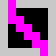

    45    85  10   0
test1: 10 0


In [2]:
print("\ntest1:",pt(td,1,1),0)


            

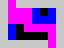

    39     8  18   0
test2: 18 18


In [3]:
print("\ntest2:",pt(td2,1,1),18)



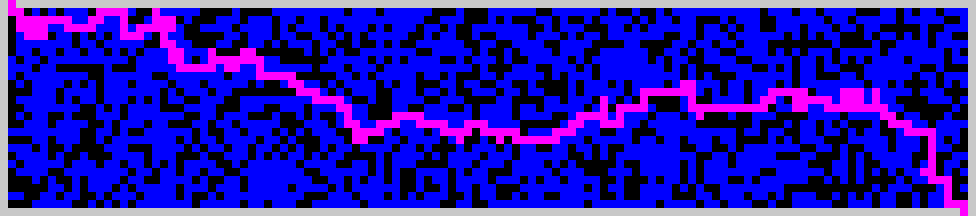

 67539  1954 290   0
part1: 290 290


In [4]:
print("\npart1:",pt(open("24.txt").read(),1),290)



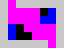

   357    37  54   0
test2: 54 54


In [5]:
print("\ntest2:",pt(td2,2,1),54)

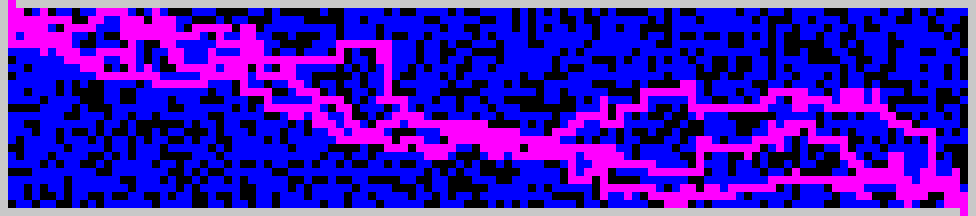

637078  4951 842   0
part2: 842 842


In [6]:
print("\npart2:",pt(open("24.txt").read(),2),842)

